## Importing libraries

In [4]:
import geopandas as gpd 
import matplotlib.pyplot as plt
import requests 
import pyproj 
import datetime as dt
from rasterio.features import Affine 
from pydap.client import open_url 
from pydap.cas.urs import setup_session 
import xarray as xr
import rioxarray 
import shapely 
import rasterio 
import time 
from shapely.geometry import mapping, Point

Versions of the following libraries for user reference:

In [5]:
print("NoteBook was produced with the following versions")
print("geopanda version  : ", gpd.__version__)
print("pyproj version    : ", pyproj.__version__)
print("rioxarray version : ", rioxarray.__version__)
print("xarray version    : ", xr.__version__)
print("shapely version   : ", shapely.__version__)
print("rasterio version  : ", rasterio.__version__)

NoteBook was produced with the following versions
geopanda version  :  0.12.2
pyproj version    :  3.4.1
rioxarray version :  0.13.3
xarray version    :  2022.12.0
shapely version   :  2.0.0
rasterio version  :  1.3.4


## Step 1. Setting Search and Subset Parameters: Spatial Area of Interest and Time Range of Interest  (Reword in final draft)

We will use a vector shape file of the [Delaware River Basin](https://www.usgs.gov/media/images/map-delaware-river-basin) to obtain boundary parameters to use in demonstrating a programmatic spatial subsetting process.

We'll use Python's [GeoPandas](https://geopandas.org/en/stable/index.html) to provide a spatial extent from a polygon file. 

- `Geopandas` is a Python library that enables the use and manipulation of geospatial data. It extends the common datatype used in pandas to allow for many and unique geometric operations. 


<Derived Projected CRS: EPSG:26918>
Name: NAD83 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 78°W and 72°W - onshore and offshore. Canada - Nunavut; Ontario; Quebec. United States (USA) - Connecticut; Delaware; Maryland; Massachusetts; New Hampshire; New Jersey; New York; North Carolina; Pennsylvania; Virginia; Vermont.
- bounds: (-78.0, 28.28, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

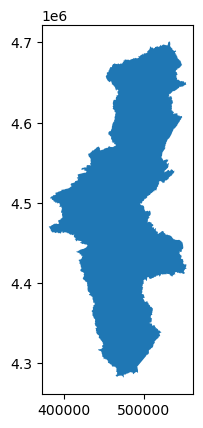

In [6]:
drb_poly = gpd.read_file('C:/Users/jinskeep/RiverBasinShapeFiles/drb_bnd_polygon.shp')
drb_poly_gdf = gpd.GeoDataFrame(drb_poly, crs=26918)
ax = drb_poly_gdf.plot() # this is the boundary file of the Delaware River Basin 

drb_poly_gdf.crs # Lists the Coordinate Reference system (crs)

As we see above, the boundary file is in the `UTM 18N` projection. Daymet is projected to the `lambert_conformal_conic (LCC)` system.

## Re-project vector file using the `GeoDataFrame.to_crs`

We'll need bounding box coordinates in 2 referrence systems

1. **Geographic** - for searching NASA Earthdata metadata
2. **Lambert Conformal Conic** - Daymet's crs - for subsetting the file using OPeNDAP protocols  

## 1.1. Spatial Aspect of Subsetting Data: Geographic bounding box - for searching NASA Earthdata metadata

In [7]:
# Let's determine and store the geographic bounding box of the Park boundary for Earthdata Searching
# data can be re-projected using the GeoDataFrame.to_crs() command:
drb_poly_4326 = drb_poly_gdf.to_crs(epsg=4326) #EPSG code for WGS84
drb_poly_4326.crs
xy = drb_poly_4326.bounds # bound of polygon in lat, lon 


print(xy)

        minx       miny       maxx       maxy
0 -76.395556  38.684285 -74.357594  42.462467


In [8]:
xy = drb_poly_4326.bounds.values.tolist()[0] # We'll need the bounding box as a Python list
                                             # To server as a subsetting parameter 
print(xy)

[-76.3955564473366, 38.684285214030574, -74.35759388883694, 42.4624674806303]


## 1.2. Spatial Aspect of Subsetting Data: Lambert Conformal Conic bounding box- Daymet's CRS - for subsetting the file using OPeNDAP protocols

[https://stackoverflow.com/questions/51291437/matching-points-to-raster-in-different-projections]

In [9]:
#defining Daymet proj - we'll use this in a later step
daymet_proj = "+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs"
drb_poly_lcc = drb_poly_gdf.to_crs(daymet_proj) # to_crs re-projects from UTM 17N to LCC 
lccbounds = drb_poly_lcc.bounds # bounds ini LCC projection 
lccbounds.round(2)

,minx,miny,maxx,maxy
0,1879878.71,-103658.03,2060097.39,296893.24


Text(0.5, 1.0, 'DRB Daymet LCC Projection')

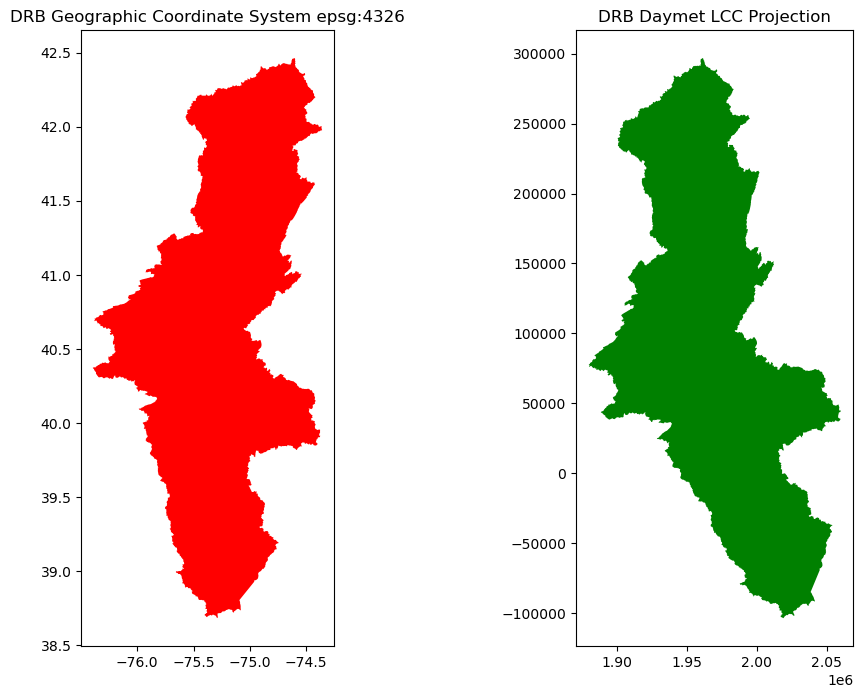

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
#drb_poly_gdf.plot(ax=ax1, facecolor='blue');
#ax1.set_title("DRB UTM Zone 18N")
drb_poly_4326.plot(ax=ax1, facecolor='red');
ax1.set_title("DRB Geographic Coordinate System epsg:4326");
drb_poly_lcc.plot(ax=ax2, facecolor='green');
ax2.set_title("DRB Daymet LCC Projection")

## 1.3. Temporal Aspect: Need to also dfine a `time range` in a format that the API recognizes, and the Daymet `variable` of interest

In [11]:
start_date = dt.datetime(1980, 1, 1)
end_date = dt.datetime(2021, 1, 1)

dt_format = '%Y-%m-%dT%H:%M:%SZ' #format requirement for datetime search 
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

var = 'prcp' # select a Daymet variable of interest 
print(temporal_str)
print(var)

1980-01-01T00:00:00Z,2021-01-01T00:00:00Z
prcp


## Step 2. Leveraging NASA's Common Metadata Repository (CMR) API to serch for Daymet data within a spatial and temporal region of interest 

Now that we've defined our spatial and temporal area-of-interest, we'll see how we can programatically use those as a search parameters to discover Daymet V4 daily data.

At the end of this step, we will have a list of Daymet files that are within our search criteria (bounding box and time period)

### A little background...

- Searching [NASA's Earthdata Holdings](https://search.earthdata.nasa.gov/search) can lead to quite a few files for a user to consider.

Some helpful background:

- NASA has a metadata system that catlogs all data and metadata records: [Common Metadata Repository (CMR)](https://www.earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/cmr)

- Using the [CMR API](https://cmr.earthdata.nasa.gov/search), we can search metadata records to discovered data granules (files). 

`Request URL's`

[https://cmr.earthdata.nasa.gov/search/collections]

[https://cmr.earthdata.nasa.gov/search/granules]

- The [Daymet V4 Daily](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1840) data DOI, `doi.org/10.3334/ORNLDAAC/1840`


## 2.1. Searching NASA's Earthdata Collections for Daymet V4 Daily Data "`Concept ID`"

### The `Concept ID` is a NASA Earthdata unique ID for **Dataset Collections**. We'll see how to programmatically obtain the Concept ID below. 

- `requests` is a simple HTTP library for Python. It allows you to easily send HTTP requests. 

[https://cmr.earthdata.nasa.gov/search/collections]

To build the URL request we'll use:

- The CMR Request URL
- Daymet V4 Daily Data DOI 

In [15]:
daymet_doi = 'doi.org/10.3334/ORNLDAAC/2129' # define the Daymet V4 Daily Data DOI (Digital Object Identifier) as the variable 'daymet_doi'
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable "cmrurl"
doisearch = cmrurl + 'collections.json?doi' + daymet_doi # Create the Earthdata collections URL 
print('Earthdata Collections URL: Daymet V4 Daily -->', doisearch)

Earthdata Collections URL: Daymet V4 Daily --> https://cmr.earthdata.nasa.gov/search/collections.json?doidoi.org/10.3334/ORNLDAAC/2129


In [16]:
# From the doisearch, we can obtain the ConceptID for the Daymet V4 Daily data
# We'll search the json response of the Daymet metadata for "id" within the 'entry' dictionary key
response = requests.get(doisearch)
collection = response.json()['feed']['entry'][0]
#print(collection)
concept_id = collection['id']
print('NASA Earthdata Concept_ID --> ' , concept_id)

NASA Earthdata Concept_ID -->  C2532074577-AMD_USAPDC


`C2532074577-AMD_USAPDC` is the unique NASA-given Concept ID for the Daymet V4 Daily data collection. We'll use this to search for the Daymet V4 Daily files (granules) that match our search criteria.

## 2.2. Searching NASA's Earthdata Holdings for Daymet `Granules` (Files)

#### Now that we have all our parameters defined, let's search NASA's Earthdata Granules for all the data that are within those search criteria.

https://cmr.earthdata.nasa.gov/search/granules

In [17]:
print('Variables we have defined to pass to the CMR API')
print('-----------------------------------------------')
print('time range      :', temporal_str)
print('Daymet variable :', var)
print('bounding box    :')
print(xy)
print('concept ID      :', concept_id)
print('cmr url         :', cmrurl)

Variables we have defined to pass to the CMR API
-----------------------------------------------
time range      : 1980-01-01T00:00:00Z,2021-01-01T00:00:00Z
Daymet variable : prcp
bounding box    :
[-76.3955564473366, 38.684285214030574, -74.35759388883694, 42.4624674806303]
concept ID      : C2532074577-AMD_USAPDC
cmr url         : https://cmr.earthdata.nasa.gov/search/


## 2.2.a. We'll build a Request URL `granulesearch` to create a listing of all the granules (files) in NASA's Earthdata holdings that fit the search criteria we defined.

In [18]:
granulesearch = cmrurl + 'granules.json?collection_concept_id=' + concept_id + \
                '&page_size=1000' + '&temporal=' + temporal_str + \
                '&bounding_box[]=' + ','.join(map(str, xy))
print(granulesearch) 

https://cmr.earthdata.nasa.gov/search/granules.json?collection_concept_id=C2532074577-AMD_USAPDC&page_size=1000&temporal=1980-01-01T00:00:00Z,2021-01-01T00:00:00Z&bounding_box[]=-76.3955564473366,38.684285214030574,-74.35759388883694,42.4624674806303


## 2.2.b. Again using Python's `requests` library, we can provide the URL `granulesearch` to create a listing of all the granules (files) in NASA's Earthdata holdings that fit the search criteria we defined.

In [19]:
response = requests.get(granulesearch)
granules = response.json()['feed']['entry']  # Michele, look at url feed, 'entry' key in the granulesearch URL {}
granule_names = []  # create an empty array
for g in granules:
    granule_name = g['title'] # fill the array with granule names that match our search parameters
    if var in granule_name:
        granule_names.append(granule_name)
        print(granule_name)

Now the array `granule_names` contains the names of all the files that have data in the DRB and for our time period. 

In other words, of the 1,071 files in the daymet V4 Daily collection, these 2 files match our search criteria.

## Step 3. Downloading subset data through ORNL DAAC THREDDS Data Server 

Daymet V4 Daily data is available through ORNL DAAC's THREDDS Data Server. 

[https://daac.ornl.gov/cgi-bin/dataset_lister.pl?p=32]

## Step 3.1. `OPeNDAP` allows users to use data files that are stored on remote computers with their favorite analysis and visualization client software 

Daymet V4 Daily data is available through ORNL DAAC's THREDDS Data Server 

NASA Earthdata has great information on OPeNDAP: [What is OPeNDAP](https://www.earthdata.nasa.gov/engage/open-data-services-and-software/api/opendap)

## 3.1.a. We'll use Pythons pydap library 
- `pydap` can be used to inspect data from any scientific dataset available on the internet from OPeNDAP servers. This allows inspection and manipulation of scientific data as if it were stored locally. Data can be downloaded on-the-fly as needed.

## 3.1.b. We'll use Python's `Xarray` Library to 

- open the data files we are searching for.
- subset the North American file based on the Lambert conformal conic `lccbounds` bounding box we defined earlier
- concatenate the time range of files into one file, and 
- save the concatened file to a netCDF file

Pydap

- open_url

Xarray

- open_dataset
- slice
- concat
- to_netcdf

We will subset and download Daymet V4 Daily Data based on 

- `granule_names` array we saved above
- our polygonal region of interest (LCC bounding box)
- our time range of interest
- Daymet variable

**Note:** The beginning of the `granule_names` filename ("**Daymet_Daily_V4.**") is specific to the Earthdata naming convention. We'll strip out ("**Daymet_Daily_V4.**") below when we accesss the files from the on-pre ORNL DAAC's OPeNDAP client through THREDDS

In [63]:
import numpy as np

years_daymet = np.arange(1980, 1985) # Numpy array 1980 - 1984

before = time.time()
cnt = 0
# proceed with for loop that will iterate through the numpy array and download each file from the url
for year in years_daymet:
    thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_' + str(year) + '.nc'
    print(thredds_url)
#before = time.time()
#cnt = 0

    #using pydap's open_url
    thredds_ds = open_url(thredds_url)

    # Xarray DataSet - opening dataset via remote OPeNDAP
    ds = xr.open_dataset(xr.backends.PydapDataStore(thredds_ds), decode_coords="all")

    temp=ds['prcp'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]))

    if cnt==0:
       prcp = temp
    else:
        prcp = xr.concat([prcp, temp], dim="time")
    cnt +=1

# save to netcdf
prcp.to_netcdf(var + 'daymet_tdssubset_1980_to_2021.nc')
#print("Processing Time: ", time.time() -before, 'seconds')

https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_1980.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_1981.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_1982.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_1983.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_1984.nc


## 3.2. Visualize Daymet Precipitation Subset 

In [14]:
prcp_drb = prcp.isel(time=7) # # isel = xarray index selection (python index start from 0, so time is Jan 7, 2010)
fig, ax = plt.subplots(figsize = (20,10))
prcp_drb.plot(ax=ax, robust=True, cbar_kwargs={'label':'mm/day'})
drb_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'red')

NameError: name 'prcp' is not defined

In [57]:
prcp

<xarray.DataArray 'prcp' (time: 730, y: 400, x: 180)>
array([[[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.  , ...,  nan,  nan,  nan],
        [0.  , 0.  , 0.  , ...,  nan,  nan,  nan],
        [0.  , 0.  , 0.  , ...,  nan,  nan,  nan]],

       [[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [4.54, 4.53, 4.53, ...,  nan,  nan,  nan],
        [4.53, 4.55, 4.57, ...,  nan,  nan,  nan],
        [4.57, 4.59, 4.59, ...,  nan,  nan,  nan]],

       [[5.49, 5.41, 5.35, ..., 2.65, 2.6 , 2.56],
        [5.49, 5.48, 5.36, ..., 2.66, 2.61, 2.57],
        [5.49, 5.46, 5.44, ..., 2.67, 2.62, 2.58],
        ...,
...
        ...,
        [6.18, 6.31, 6.45, ...,  nan,  nan,  nan],
        [6.06, 6.23, 6.36, ...,  nan,  nan,  nan],
        [5.97, 6.16, 6.31, ...,  nan,  nan,  nan]],

       [[0.63, 0.57, 0.51, ..., 0.96, 0.96, 0.96],
        [0.66, 0.63, 0.54, ..., 0.95, 0.95, 0.95],
        [0.69, 0.65, 0.62, ..., 0.93, 0.93, 0.93],
        ...,
        [1.35, 1.3 , 1.24, ...,  nan,  nan,  nan],
        [1.3 , 1.24, 1.2 , ...,  nan,  nan,  nan],
        [1.24, 1.19, 1.15, ...,  nan,  nan,  nan]],

       [[0.88, 0.85, 0.82, ..., 0.7 , 0.71, 0.73],
        [0.89, 0.86, 0.83, ..., 0.7 , 0.71, 0.73],
        [0.9 , 0.87, 0.85, ..., 0.69, 0.71, 0.72],
        ...,
        [1.41, 1.47, 1.52, ...,  nan,  nan,  nan],
        [1.38, 1.46, 1.52, ...,  nan,  nan,  nan],
        [1.35, 1.46, 1.53, ...,  nan,  nan,  nan]]], dtype=float32)
Coordinates:
  * x                        (x) float32 1.881e+06 1.882e+06 ... 2.06e+06
  * y                        (y) float32 2.96e+05 2.95e+05 ... -1.03e+05
    lat                      (y, x) float32 42.68 42.67 42.67 ... 38.59 38.58
    lon                      (y, x) float32 -75.59 -75.58 ... -74.93 -74.91
  * time                     (time) datetime64[ns] 2020-01-01T12:00:00 ... 20...
    lambert_conformal_conic  int16 -32767
Attributes:
    long_name:     daily total precipitation
    units:         mm/day
    cell_methods:  area: mean time: sum
    _ChunkSizes:   [10, 300, 300]

## Step 4: Clipping the subset area by polygon 

In this step, we demonstrate how to clip the subset to our polygon of interest. We'll use Python's *rasterio* library. 

- `rasterio` provides many capabilities found in GDAL 

First. we'll map the subset precipitation data matrix to the real world coordinates using the '**translation**' and '**scale**' methods of '**Affine**'

`rasterio` needs the affine transform parameter to convert polygon into mask

In [65]:
from rasterio.features import Affine
res = 1000 # daymet spatial resolution is 1km x 1km
transform = Affine.translation(min(prcp.x).values - res / 2, min(prcp.y).values - res / 2) * Affine.scale(res, res)
transform

Affine(1000.0, 0.0, 1880250.0,
       0.0, 1000.0, -103500.0)

- We'll use the `transform` defined above and mask the prcp data to the park boundary

In [66]:
from rasterio.features import geometry_mask 

In [67]:
drb_mask = geometry_mask(drb_poly_lcc.geometry, out_shape=(len(prcp.y), len(prcp.x)), transform=transform, invert=True)
polymask = xr.DataArray(drb_mask , dims=("y", "x"))
polymask = polymask.sel(y=slice(None, None, -1))
prcp_masked = prcp.where(polymask == True)
prcp_masked.to_netcdf(var + 'DaymetV4_subset_poly_prcp_1980_to_2021.nc')


Now let's plot the subset for a day, this time using Xarray's **sel** method for time

<AxesSubplot: title={'center': 'time = 1983-01-10T12:00:00, lambert_conformal_c...'}, xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

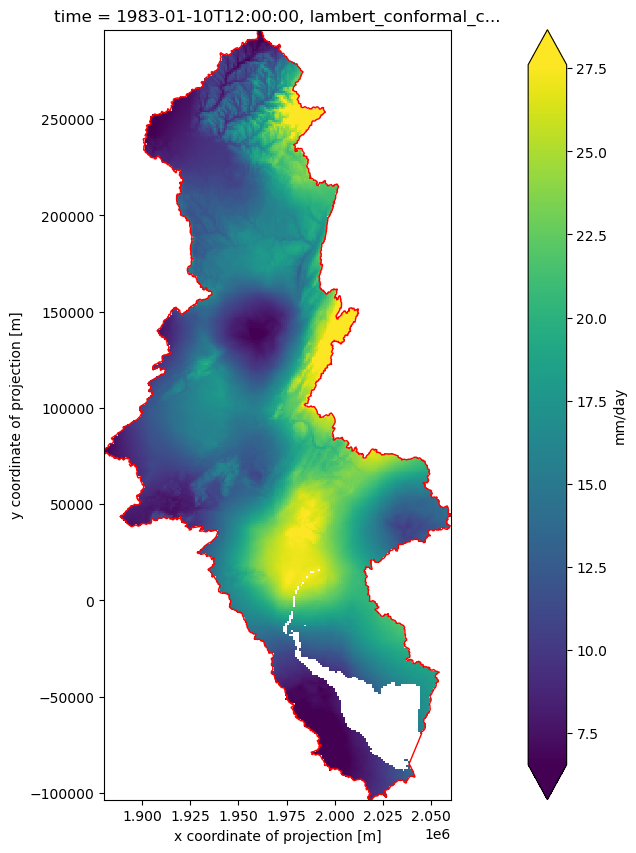

In [80]:
import matplotlib.pyplot as plt
prcp_1 = prcp_masked.sel(time="1983-01-10")
fig, ax = plt.subplots(figsize = (20,10))
prcp_1.plot(ax=ax, robust=True, cbar_kwargs={'label': 'mm/day'})
drb_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'red')

In [81]:
prcp_1

<xarray.DataArray 'prcp' (time: 1, y: 400, x: 180)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x                        (x) float32 1.881e+06 1.882e+06 ... 2.06e+06
  * y                        (y) float32 2.96e+05 2.95e+05 ... -1.03e+05
    lat                      (y, x) float32 42.68 42.67 42.67 ... 38.59 38.58
    lon                      (y, x) float32 -75.59 -75.58 ... -74.93 -74.91
  * time                     (time) datetime64[ns] 1983-01-10T12:00:00
    lambert_conformal_conic  int16 -32767
Attributes:
    long_name:     daily total precipitation
    units:         mm/day
    cell_methods:  area: mean time: sum
    _ChunkSizes:   [1, 1000, 1000]

In [82]:
prcp_masked


<xarray.DataArray 'prcp' (time: 1825, y: 400, x: 180)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x                        (x) float32 1.881e+06 1.882e+06 ... 2.06e+06
  * y                        (y) float32 2.96e+05 2.95e+05 ... -1.03e+05
    lat                      (y, x) float32 42.68 42.67 42.67 ... 38.59 38.58
    lon                      (y, x) float32 -75.59 -75.58 ... -74.93 -74.91
  * time                     (time) datetime64[ns] 1980-01-01T12:00:00 ... 19...
    lambert_conformal_conic  int16 -32767
Attributes:
    long_name:     daily total precipitation
    units:         mm/day
    cell_methods:  area: mean time: sum
    _ChunkSizes:   [1, 1000, 1000]